In [1]:
!pip install pytorch-msssim -q
!pip install umap -q
!pip install umap-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from astropy.io import fits
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
from glob import glob
import cv2, os
from scipy import ndimage
import matplotlib.pyplot as plt
from pytorch_msssim import MS_SSIM, SSIM
from timm.models.vision_transformer import Block
from skimage.feature import hog, local_binary_pattern
from skimage.measure import regionprops, moments
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from functools import partial
import torch
import torch.nn.functional as F

folder_path = "/kaggle/input/exxa-continuum/new_clean/new_clean"
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dr = 2
patch_size = 16
print(f"Running on {device.upper()}")

Running on CUDA


In [3]:
import pickle 
with open("/kaggle/input/exxa-continuum/clean_feats/new_clean_radial_feats.pkl", 'rb') as handle:
    img_feats = pickle.load(handle)

In [5]:
import logging
import math
from typing import Callable, Dict, List, Optional, Tuple, Union
from torch import nn as nn

from timm.layers.helpers import to_2tuple
from timm.layers.format import Format, nchw_to
from timm.layers.trace_utils import _assert

class PatchEmbed(nn.Module):
    """ 2D Image to Patch Embedding
    """
    output_fmt: Format
    dynamic_img_pad: torch.jit.Final[bool]

    def __init__(
            self,
            img_size: Union[int, Tuple[int, int]] = 224,
            patch_size: int = 16,
            in_chans: int = 1,
            embed_dim: int = 768,
            radial_dim: int = 168,
            norm_layer: Optional[Callable] = None,
            flatten: bool = True,
            output_fmt: Optional[str] = None,
            bias: bool = True,
            strict_img_size: bool = True,
            dynamic_img_pad: bool = False,
            dr: int = 2,
            fusion: str = 'concat'
    ):
        super().__init__()
        self.patch_size = to_2tuple(patch_size)
        self.img_size, self.grid_size, self.num_patches = self._init_img_size(img_size)
        if output_fmt is not None:
            self.flatten = False
            self.output_fmt = Format(output_fmt)
        else:
            # flatten spatial dim and transpose to channels last, kept for bwd compat
            self.flatten = flatten
            self.output_fmt = Format.NCHW
        self.strict_img_size = strict_img_size
        self.dynamic_img_pad = dynamic_img_pad
        self.fusion = fusion
        if (fusion == 'concat'):
            embed_dim = embed_dim // 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size, bias=bias)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()
        self.radial_proj = nn.Sequential(
            nn.Linear(radial_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim),
        )
        self.dr = dr

    def _init_img_size(self, img_size: Union[int, Tuple[int, int]]):
        assert self.patch_size
        if img_size is None:
            return None, None, None
        img_size = to_2tuple(img_size)
        grid_size = tuple([s // p for s, p in zip(img_size, self.patch_size)])
        num_patches = grid_size[0] * grid_size[1]
        return img_size, grid_size, num_patches

    def set_input_size(
            self,
            img_size: Optional[Union[int, Tuple[int, int]]] = None,
            patch_size: Optional[Union[int, Tuple[int, int]]] = None,
    ):
        new_patch_size = None
        if patch_size is not None:
            new_patch_size = to_2tuple(patch_size)
        if new_patch_size is not None and new_patch_size != self.patch_size:
            with torch.no_grad():
                new_proj = nn.Conv2d(
                    self.proj.in_channels,
                    self.proj.out_channels,
                    kernel_size=new_patch_size,
                    stride=new_patch_size,
                    bias=self.proj.bias is not None,
                )
                new_proj.weight.copy_(resample_patch_embed(self.proj.weight, new_patch_size, verbose=True))
                if self.proj.bias is not None:
                    new_proj.bias.copy_(self.proj.bias)
                self.proj = new_proj
            self.patch_size = new_patch_size
        img_size = img_size or self.img_size
        if img_size != self.img_size or new_patch_size is not None:
            self.img_size, self.grid_size, self.num_patches = self._init_img_size(img_size)

    def feat_ratio(self, as_scalar=True) -> Union[Tuple[int, int], int]:
        if as_scalar:
            return max(self.patch_size)
        else:
            return self.patch_size

    def dynamic_feat_size(self, img_size: Tuple[int, int]) -> Tuple[int, int]:
        """ Get grid (feature) size for given image size taking account of dynamic padding.
        NOTE: must be torchscript compatible so using fixed tuple indexing
        """
        if self.dynamic_img_pad:
            return math.ceil(img_size[0] / self.patch_size[0]), math.ceil(img_size[1] / self.patch_size[1])
        else:
            return img_size[0] // self.patch_size[0], img_size[1] // self.patch_size[1]

    def radial_forward(self, p):
        B = len(p)
        radial_feats = []
        for i in range(B):
            feat = np.array(img_feats[p[i]]).astype(np.float32)
            radial_feats.append(feat)

        radial_feats = torch.tensor(radial_feats, dtype = torch.float32).to(device) # (B, L, radial_dim)
        x_rad = self.radial_proj(radial_feats)
        return x_rad

    def forward(self, x, p):
        B, C, H, W = x.shape
        if self.img_size is not None:
            if self.strict_img_size:
                _assert(H == self.img_size[0], f"Input height ({H}) doesn't match model ({self.img_size[0]}).")
                _assert(W == self.img_size[1], f"Input width ({W}) doesn't match model ({self.img_size[1]}).")
            elif not self.dynamic_img_pad:
                _assert(
                    H % self.patch_size[0] == 0,
                    f"Input height ({H}) should be divisible by patch size ({self.patch_size[0]})."
                )
                _assert(
                    W % self.patch_size[1] == 0,
                    f"Input width ({W}) should be divisible by patch size ({self.patch_size[1]})."
                )
        if self.dynamic_img_pad:
            pad_h = (self.patch_size[0] - H % self.patch_size[0]) % self.patch_size[0]
            pad_w = (self.patch_size[1] - W % self.patch_size[1]) % self.patch_size[1]
            x = F.pad(x, (0, pad_w, 0, pad_h))
        x_rad = self.radial_forward(p) # (N, L, radial_dim)
        x = self.proj(x)
        if self.flatten:
            x = x.flatten(2).transpose(1, 2) 
        elif self.output_fmt != Format.NCHW:
            x = nchw_to(x, self.output_fmt)
        x = self.norm(x) # (N, L, embed_dim-radial_dim)
        if (self.fusion == 'concat'):
            x = torch.cat([x, x_rad], dim = -1)
        elif (self.fusion == 'add'):
            x = x + x_rad
        elif (self.fusion == 'no'):
            x = x
        return x

In [6]:
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def interpolate_pos_embed(model, checkpoint_model):
    if 'pos_embed' in checkpoint_model:
        pos_embed_checkpoint = checkpoint_model['pos_embed']
        embedding_size = pos_embed_checkpoint.shape[-1]
        num_patches = model.patch_embed.num_patches
        num_extra_tokens = model.pos_embed.shape[-2] - num_patches
        # height (== width) for the checkpoint position embedding
        orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
        # height (== width) for the new position embedding
        new_size = int(num_patches ** 0.5)
        # class_token and dist_token are kept unchanged
        if orig_size != new_size:
            print("Position interpolate from %dx%d to %dx%d" % (orig_size, orig_size, new_size, new_size))
            extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
            # only the position tokens are interpolated
            pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
            pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(0, 3, 1, 2)
            pos_tokens = torch.nn.functional.interpolate(
                pos_tokens, size=(new_size, new_size), mode='bicubic', align_corners=False)
            pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
            new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
            checkpoint_model['pos_embed'] = new_pos_embed

In [7]:
class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=1,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False, radial_dim = 168, dr = 2, fusion='concat'):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim, radial_dim, dr = dr, fusion = fusion)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        self.msssim = MS_SSIM(data_range=1.0, win_size=3, channel=1)
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 1, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 1))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 1))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 1, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, p, mask_ratio):
        # embed patches
        x = self.patch_embed(x, p)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5
        
        mse_loss = (pred - target) ** 2
        mse_loss = mse_loss.mean(dim=-1)  # [N, L], mean loss per patch

        mse_loss = (mse_loss * mask).sum() / mask.sum()  # mean loss on removed patches
        pred_4d = pred.unsqueeze(1)
        target_4d = target.unsqueeze(1)
        ssim_loss = self.msssim(pred_4d, target_4d)
        return mse_loss, ssim_loss

    def forward(self, imgs, p, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, p, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        mse_loss, ssim_loss = self.forward_loss(imgs, pred, mask)
        return mse_loss, ssim_loss, pred, mask

# function to initialize moodel
def mae_vit_base_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=768*2, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

In [8]:
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
transform= A.Compose(
    [
        A.Normalize(
            mean=0, 
            std=1, 
            max_pixel_value=1.0,  # Adjust based on your image values
            always_apply=True,
        ),
        A.LongestMaxSize(max_size=256, always_apply=True),
        A.PadIfNeeded(
            min_height=256, 
            min_width=256, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0, 
            always_apply=True
        ),
        A.Resize(
            height=224,
            width=224,
            always_apply=True
        ),
        ToTensorV2(),
    ]
)

class FITSDataset(Dataset):
    def __init__(self, fits_paths, transform = None,
                 apply_clipping=True, expand_channels=False):
        self.paths = fits_paths
        self.apply_clipping = apply_clipping
        self.expand_channels=expand_channels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_data = fits.getdata(self.paths[idx])
        if ('new' not in folder_path and 'dirty' not in folder_path):
            img_data = img_data[0]
            img_data = img_data.squeeze()
        img_data = img_data.astype(np.float32, copy=True)
        
        if (self.apply_clipping):
            lower_percentile = np.percentile(img_data, 1)  # 1st percentile
            upper_percentile = np.percentile(img_data, 99)  # 99th percentile
            img_data = np.clip(img_data, lower_percentile, upper_percentile)
        
        if self.transform is not None:
            img_data = self.transform(image=img_data)
            if (self.expand_channels):
                img_data['image'] = img_data['image'].repeat(3, 1, 1)
            return {
                'img_data': img_data['image'],
                'img_path': self.paths[idx]
            }
        else:
            return {
                'img_data': img_data
            }


In [9]:
from torch import optim
def train_fn(model, train_loader, optimizer, device, criterion=None):
    model.train().to(device)
    it_loss = 0
    counter = 0
    for i, data in enumerate(tqdm(train_loader,total = len(train_loader))):
        imgs = data['img_data'].to(device)
        img_path = data['img_path']
        optimizer.zero_grad()
        
        if (criterion is None):
            mse_loss, ssim_loss, _, _ = model(imgs, img_path)
            loss = mse_loss + (1 - ssim_loss)
        else:
            reconstructed, _ = model(imgs)
            loss, _, _ = criterion(reconstructed, imgs)
            
        loss.backward()
        optimizer.step()
        it_loss += loss.item() * imgs.shape[0]
        counter += imgs.shape[0]
    return it_loss/counter

def test_fn(model, test_loader, device, criterion=None):
    model.eval().to(device)
    it_mse = 0
    it_ssim = 0
    counter = 0
    for i, data in enumerate(tqdm(test_loader,total = len(test_loader))):
        imgs = data['img_data'].to(device)
        img_path = data['img_path']
        with torch.no_grad():
            if (criterion is None):
                mse_loss, ssim_loss, _, _ = model(imgs, img_path)
            else:
                reconstructed, _ = model(imgs)
                _, mse_loss, ssim_loss = criterion(reconstructed, imgs)
                
            it_mse += mse_loss.item() * imgs.shape[0]
            it_ssim += ssim_loss.item() * imgs.shape[0]
            counter += imgs.shape[0]
    return it_ssim/counter, it_mse/counter

def run_epochs(model, train_loader, test_loader, save_dir, 
               epochs=30, lr=1.5e-4, optimizer='adam', scheduler=None, 
               weight_decay=0.01, criterion=None, data_type='images'):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if (optimizer == 'adam'):
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif (optimizer == 'adamw'):
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif (optimizer == 'radam'):
        optimizer = optim.RAdam(model.parameters(), lr=lr, weight_decay = weight_decay)
    elif (optimizer == 'sgd'):
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay = weight_decay)
    elif (optimizer == 'rmsprop'):
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay = weight_decay)
    else:
        print("Unknown optimzer, pass optimizer object instead for this")
        return 

    
    if (scheduler.lower() == 'reducelronplateau'):
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
    elif (scheduler.lower() == 'cosineannealinglr'):
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs)
    elif (scheduler.lower() == 'exponentiallr'):
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    else:
        print("Unknown scheduler, pass scheduler object instead for this")
        return 

    if (criterion is not None and criterion.lower() == 'hybridloss'):
        criterion = HybridLoss(data_type)

    best_loss = float('inf')
    best_ssim = 0.0
    best_mse = float('inf')
    for epoch in range(epochs):
        train_loss = train_fn(model, train_loader, optimizer, device, criterion)
        test_ssim, test_mse = test_fn(model, test_loader, device, criterion)
        total_loss = (1 - test_ssim) + test_mse
        if (scheduler is not None):
            scheduler.step(total_loss)

        if (total_loss < best_loss):
            best_loss = total_loss
            best_ssim = test_ssim
            best_mse = test_mse
            torch.save({
                'model_dict':model.state_dict(),
                'optimizer_dict':optimizer.state_dict()
            }, save_dir)

            print('MODEL SAVED!')
        print(f'Epoch {epoch+1}, Train loss: {train_loss:.6f}, Test MSE : {test_mse:.6f}, Test MS-SSIM : {test_ssim:.6f}')
    return best_ssim, best_mse, save_dir

In [10]:
image_paths = sorted(glob(os.path.join(folder_path, "*.fits")))
image_modelling_dataset = FITSDataset(image_paths, transform = transform)
train_ratio = 0.8
train_size = int(train_ratio * len(image_modelling_dataset))
test_size = len(image_modelling_dataset) - train_size
radial_dim = get_patchwise_radial_feats(image_modelling_dataset[0]['img_data'], patch_size, dr).shape[-1]
train_dataset, test_dataset = random_split(image_modelling_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 4, shuffle = False)

In [11]:
torch.cuda.empty_cache()

In [12]:
model = mae_vit_base_patch16_dec512d8b(radial_dim = radial_dim, dr = dr)
save_dir = "./best_MAE_with_radialfeats.pth"
#criterion is none since it is implemented in model class

best_ssim, best_mse, _ = run_epochs(model, train_loader, test_loader, save_dir, 
           epochs=6, lr=1.5e-4, optimizer='radam', 
           scheduler='ReduceLROnPlateau', 
           weight_decay=0.01, criterion=None, data_type='images')   

print(f"\n\nRESULTS OF MAE (Transformer based)\nMS_SSIM : {best_ssim}\nMSE : {best_mse}")

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 1, Train loss: 0.734775, Test MSE : 0.002878, Test MS-SSIM : 0.657999


  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 2, Train loss: 0.199171, Test MSE : 0.000958, Test MS-SSIM : 0.849051


  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 3, Train loss: 0.080052, Test MSE : 0.000451, Test MS-SSIM : 0.944514


  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 4, Train loss: 0.053081, Test MSE : 0.000319, Test MS-SSIM : 0.947892


  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 5, Train loss: 0.046957, Test MSE : 0.000248, Test MS-SSIM : 0.954742


  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 6, Train loss: 0.041901, Test MSE : 0.000205, Test MS-SSIM : 0.959899


RESULTS OF MAE (Transformer based)
MS_SSIM : 0.9598990052174299
MSE : 0.00020544449134598462


In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import umap.umap_ as umap

class LatentSpaceAnalyzer:
    def __init__(self, model, dataloader, model_type='vitmae'):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model
        self.dataloader = dataloader
        self.model_type = model_type
        self.latents = None
        self.images=None
        self.reduced_feats = None
        self.cluster_labels = None

    def generate_latent_space_representations(self):
        self.model.to(self.device).eval()
        self.latents = []
        self.images = []
        self.image_paths = []

        for data in tqdm(self.dataloader):
            img_data = data['img_data'].to(self.device)
            img_path = data['img_path']
            p = data['img_path']
            self.image_paths.extend(img_path)
            with torch.no_grad():
                if (self.model_type == 'vitmae'):
                    latent, _, _ = model.forward_encoder(img_data, p, 0.0)
                    latent = latent[:, :1, :] # take cls token
                    
                    latent = latent.squeeze(1).cpu().numpy()
                    #print(latent.shape)
                else:
                    _, latent = model(img_data)
                    latent = latent.cpu().numpy()
                    
                self.latents.append(latent)
                if (self.model_type == 'cae'):
                    img = data['plot_img']
    
                else:
                    img = data['img_data'].cpu().numpy()
                self.images.append(img)
        self.latents = np.vstack(self.latents)
        self.images = np.vstack(self.images)
        return self.latents, self.images

    # check variance for pca and reduce_dim
    def reduce_dim(self, method = 'umap', n_components=5, random_state=42):
        if (len(self.latents) == 0):
            print("Run generate_latent_space_representations() first!!")
            return 
        if method == 'tsne':
            reducer = TSNE(n_components=n_components, random_state=random_state)
            self.reduced_feats = reducer.fit_transform(self.latents)
        elif method == 'pca':
            reducer = PCA(n_components=n_components, random_state=random_state)
            self.reduced_feats = reducer.fit_transform(self.latents)
        elif method == 'umap':
            reducer = umap.UMAP(n_components=n_components, random_state=random_state)
            self.reduced_feats = reducer.fit_transform(self.latents)

        return self.reduced_feats

    def cluster_images(self, method='spectral', n_clusters=3, random_state=42):
        self.clustering_method = method
        if (method=='spectral'):
            clusterer = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize', 
                                           affinity='nearest_neighbors', 
                                           random_state=random_state)
        if (method=='kmeans'):
            clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
            
        self.cluster_labels = clusterer.fit_predict(self.reduced_feats)
        self.n_clusters = len(np.unique(self.cluster_labels))

        return self.cluster_labels

    def visualize_clusters(self, figsize=(12, 10)):
        if (self.cluster_labels is None):
            print("Run cluster_images() first!!")
            return 
        if (self.reduced_feats is None):
            print("Run reduce_dim() first!!")
            return 
            
        plt.figure(figsize=figsize)
        scatter = plt.scatter(
            self.reduced_feats[:, 0], 
            self.reduced_feats[:, 1], 
            c=self.cluster_labels, 
            cmap='viridis', 
            alpha=0.8,
            s=50
        )
        plt.colorbar(scatter, label='Cluster')
        plt.title(f'Disk Clusters using {self.clustering_method.capitalize()} (n={self.n_clusters})')
        plt.xlabel('Reduced Dimension 1')
        plt.ylabel('Reduced Dimension 2')
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_cluster(self, samples_per_cluster=10):
        unique_clusters = np.unique(self.cluster_labels)
        for cluster in unique_clusters:
            if (cluster==-1):
                cluster_name = "Noise"
            else:
                cluster_name = f'Cluster {cluster}'
            cluster_indices = np.where(self.cluster_labels == cluster)[0]

            if len(cluster_indices) > 0:
                sample_indices = np.random.choice(
                    cluster_indices, 
                    size=min(samples_per_cluster, len(cluster_indices)), 
                    replace=False
                )
                n = len(sample_indices)
                cols = min(n, 3)
                rows = (n + cols - 1) // cols
                fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
                fig.suptitle(f"{cluster_name} - {len(cluster_indices)} samples", fontsize=16, fontweight = 'bold')
                axes = np.array(axes).reshape(-1)
                for i, idx in enumerate(sample_indices):
                    img = self.images[idx].squeeze()
                    file_name = self.image_paths[idx].split('/')[-1]
                    axes[i].imshow(img)  
                    axes[i].axis("off")  
                    axes[i].set_title(f"File: {file_name}")
        
                for j in range(i + 1, len(axes)):
                    axes[j].axis("off")

                plt.tight_layout()
                plt.show()

In [14]:
model = mae_vit_base_patch16_dec512d8b(radial_dim = radial_dim, dr = dr)
check_point = torch.load(save_dir)
model.load_state_dict(check_point['model_dict'])
analyzer = LatentSpaceAnalyzer(model, test_loader, model_type='vitmae')

In [15]:
temp = analyzer.generate_latent_space_representations()

  0%|          | 0/49 [00:00<?, ?it/s]

In [16]:
analyzer.latents.shape

(195, 1536)

In [17]:
n_clusters = 3
temp = analyzer.reduce_dim(method='umap', n_components=5)
temp = analyzer.cluster_images(method='spectral', n_clusters=n_clusters)

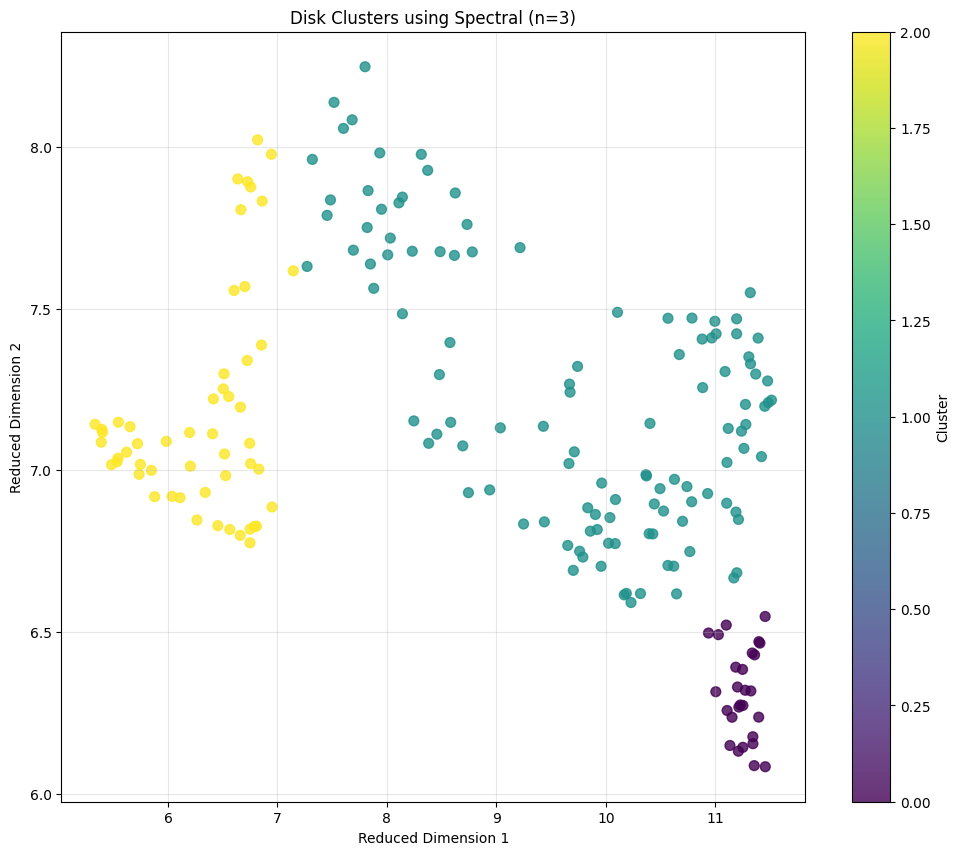

In [18]:
analyzer.visualize_clusters()

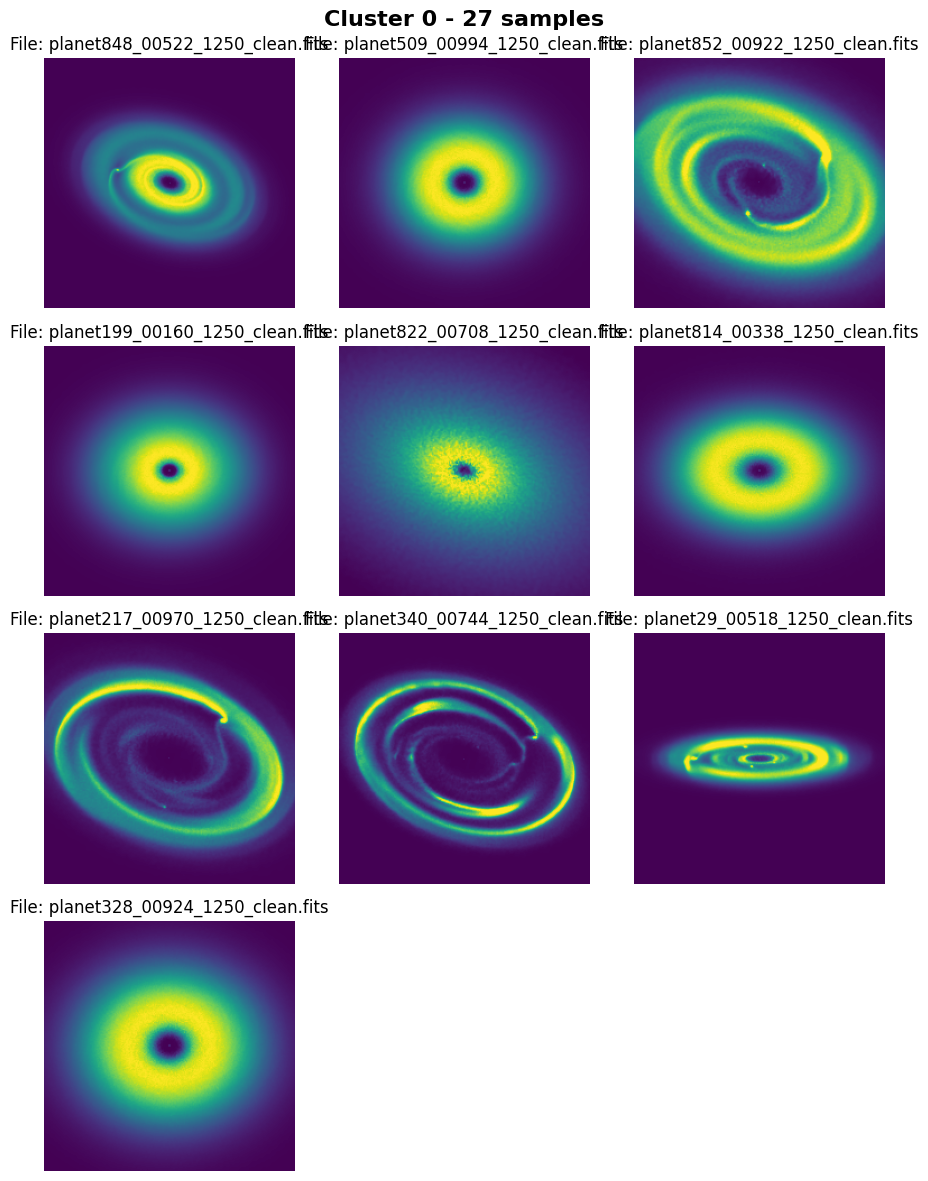

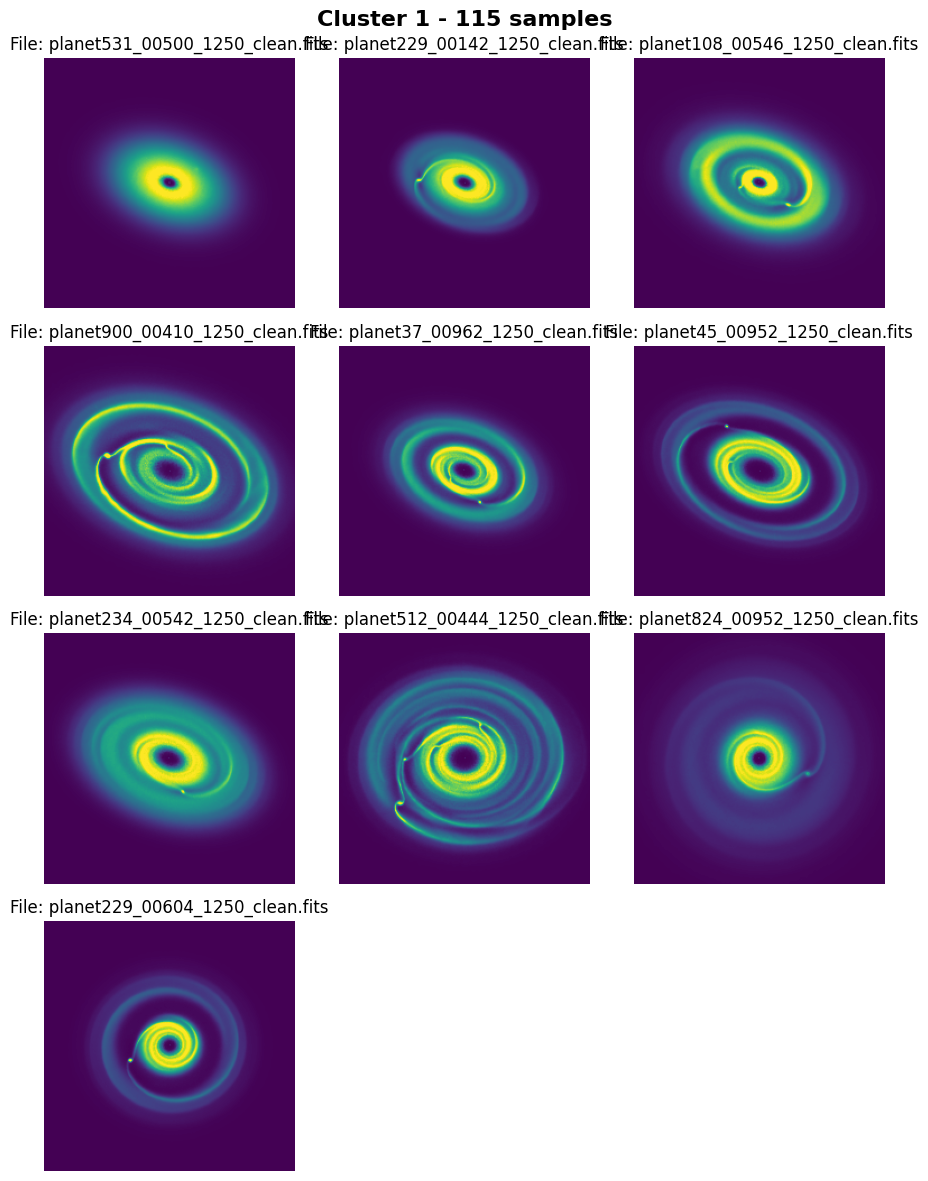

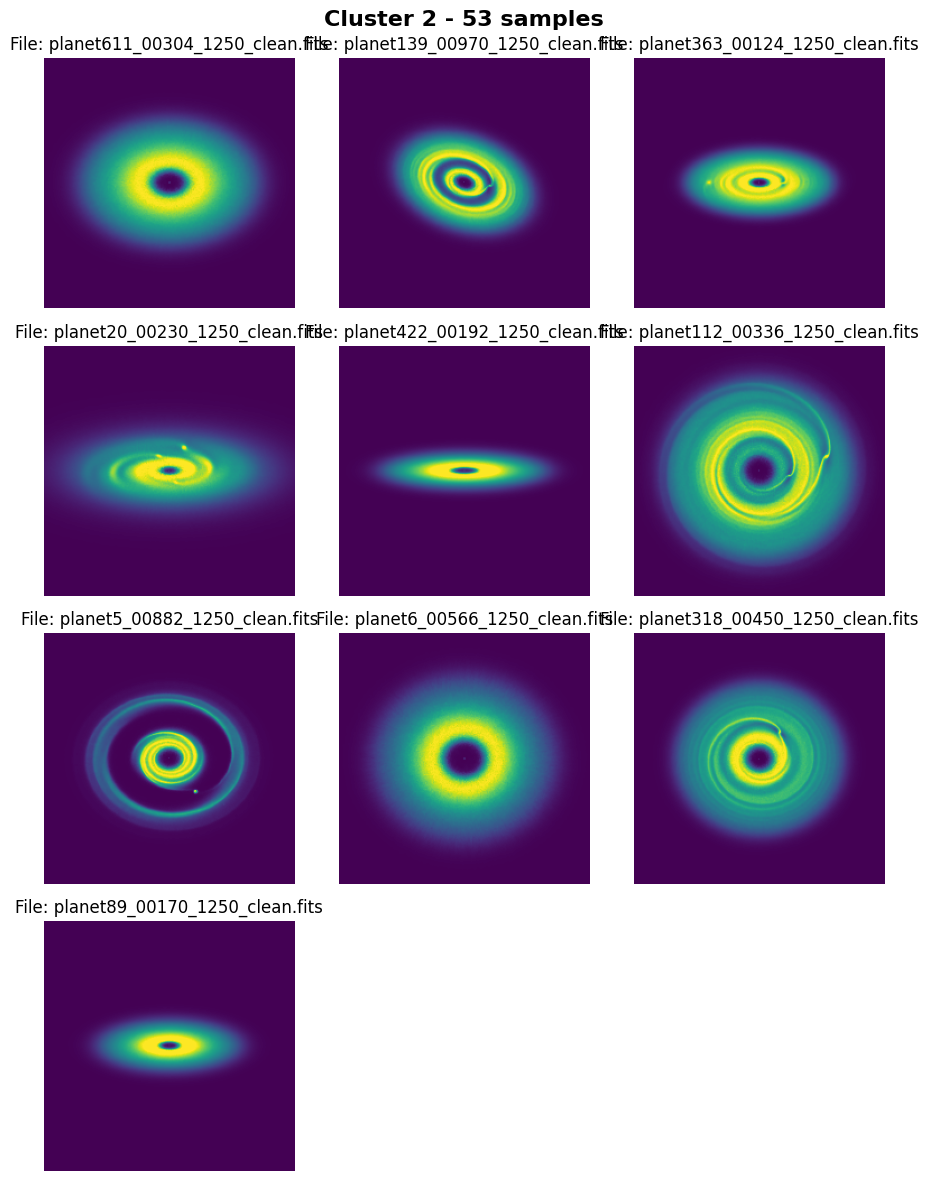

In [19]:
analyzer.plot_cluster(samples_per_cluster = 10)

In [20]:
def get_planet_name(img_path):
    file_name = img_path.split('/')[-1]
    planet = file_name.split('_')[0]
    return planet

In [21]:
planets_to_cluster = {}
for img_path in analyzer.image_paths:
    planet = get_planet_name(img_path)
    planets_to_cluster[planet] = [0 for i in range(n_clusters)] # no of samples in each cluster

for i in range(len(analyzer.image_paths)):
    planet = get_planet_name(analyzer.image_paths[i])
    cl = analyzer.cluster_labels[i]
    planets_to_cluster[planet][cl] += 1

In [22]:
tot_err = 0
cnt = 0
for planet in list(planets_to_cluster.keys()):
    a = planets_to_cluster[planet]
    mx = max(a)
    s = sum(a)
    rem = s-mx
    err = rem/s
    if (s==1):
        continue
    tot_err += err
    cnt += 1
    print(planet, err, s)
avg_err = tot_err/cnt

planet217 0.5 2
planet347 0.0 2
planet806 0.3333333333333333 3
planet113 0.0 2
planet328 0.0 2
planet254 0.0 2
planet7 0.5 2
planet366 0.5 2
planet229 0.0 3
planet907 0.0 2
planet504 0.0 3
planet159 0.0 2
planet638 0.5 2
planet814 0.0 2
planet942 0.0 2
planet41 0.0 2
planet365 0.0 3
planet319 0.0 2
planet817 0.0 4
planet533 0.0 2
planet340 0.5 2
planet208 0.0 2
planet811 0.0 2
planet919 0.5 2
planet102 0.0 3
planet900 0.5 2
planet531 0.5 2
planet45 0.0 2


In [23]:
avg_err

0.15476190476190474

In [ ]:
# EOF